# Hyperparameter Tuning

## Load data and subsample

In [38]:
import numpy as np
import pandas as pd
from time import time
from scipy.sparse import load_npz
import pickle
from gensim.utils import unpickle as gensim_unpickle

print("Importing data...")
t0 = time()
data = pd.read_pickle('data/prepped.pkl')
with open('data/feature_names.pkl', 'rb') as fp:
    feature_names = pickle.load(fp)
# cts = load_npz('data/term_counts.npz')
# tf = load_npz('data/tf.npz')
tfidf = load_npz('data/tfidf.npz')
sentences = gensim_unpickle('data/gensim_sentences.pkl')
print("done in %0.3fs" % (time()-t0))

# with open('data/temp_cross_val.pkl', 'wb') as fp:
#     pickle.dump(save_me, fp)
    
# with open('data/temp_cross_val.pkl', 'rb') as fp:
#     save_me = pickle.load(fp)


Importing data...
done in 70.312s


In [39]:
from random import sample
from sklearn.preprocessing import LabelEncoder

# One-hot encoding of subreddit
le = LabelEncoder()
subs = le.fit_transform(data.subreddit)

# Find indices for a subset of subreddits
reduce_by = 100
n = data.loc[:,'subreddit'].drop_duplicates().shape[0]
nums = sample(range(n), round(n/reduce_by))
downsample_idns = [i for i in range(subs.shape[0]) if subs[i] in nums]

# Define target and feature variables
y = subs[downsample_idns]


## Hyperparameter Tuning


In [40]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def run_hp_search(X, y, steps_var, params_var, total_n=0, reports=0, hold_n_out=False):
    '''Perform hyper-parameter search.
    X          - Input data, as numpy array or scipy sparse array
    y          - Input labels as numpy array
    steps_var  - Pipeline steps, as list of objects
    params_var - Parameter spaces to search, as list of tuples (step number, parameter name, parameter space)
    total_n    - Total number of iterations. If 0, exhaustive grid search is performed.
    reports    - Berbosity of reports: 0, 1, or 2
    hold_n_out - Perform hold-n-out cross-validation (80/20 stratified split)
    '''
    # assert steps_var is not empty, "Must provide transforms to optimize"
    # assert params_var is not empty, "Must provide hyperparameters to tune"
    # assert total_n >= 0
    # assert total_n is int
    # 
    
    n_cross_val = 3
    
    if hold_n_out:
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True, stratify=y)
    else:
        X_train = X
        y_train = y
    
    steps = []
    for i, step in enumerate(steps_var):
        steps.append((('step%d' % i),step)) # Can I get the name of an object's class as a string?
    
    parameters = {}
    param_names = []
    for param in params_var:
        param_name = steps[param[0]-1][0]+'__'+param[1]
        parameters[param_name] =  param[2]
        param_names.append('param_'+param_name)
    
    if total_n==0:
        # for param in params_var:
        #     assert param[2] is list, "GridSearchCV requires each parameter space to be a list."
        hp_search = GridSearchCV(Pipeline(steps), param_lists=parameters, # Double check variable name 'param_lists'
                                 cv=n_cross_val, random_state=42, 
                                 return_train_score=True, n_jobs=1, verbose=1)
    else:
        if total_n < n_cross_val:
            print("Increasing total number of runs to perform cross-validation.")
            total_n = n_cross_val
        n_iter_search = int(total_n/n_cross_val)
        if total_n%n_cross_val != 0:
            print("Rounding total number of runs down to stay within budget.")
        hp_search = RandomizedSearchCV(Pipeline(steps), param_distributions=parameters, n_iter=n_iter_search, 
                                       cv=n_cross_val, random_state=42, 
                                       return_train_score=True, n_jobs=1, verbose=3)
        
    t0 = time()
    print("Tuning hyper-parameters...")
    hp_search.fit(X_train, y_train)
    print("done in %0.3f seconds." % (time()-t0))
    print()
    # These reports would be better as a separate function
    # Results should be returned as a dict
    param_data = []
    for param_name in param_names:
        param_data.append(hp_search.cv_results_[param_name].data)
    results = (
        param_data,
        hp_search.cv_results_['mean_fit_time'] + hp_search.cv_results_['mean_score_time'],
        (hp_search.cv_results_['std_fit_time']**2 + hp_search.cv_results_['std_score_time']**2)*0.5,
        hp_search.cv_results_['mean_test_score'],
        hp_search.cv_results_['std_test_score'],
        hp_search.cv_results_['mean_train_score'],
        hp_search.cv_results_['std_train_score']
    )
    
    if reports >= 1:
        print("Best score: %0.3f" % hp_search.best_score_)
        print("Best parameters set:")
        best_parameters = hp_search.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
    if hold_n_out:
        print()
        print("Hold-N-Out Cross-Validation")
        print()
        print("")
        t0 = time()
        y_pred = hp_search.predict(X_test)
        print("done in %0.3fs" % (time()-t0))
        print()
        if reports>=1:
            print("Accuracy: %0.3f" % sum(y_pred==y_test)/len(y_test))
        if reports >= 2:
            # Should test that F1 score is defined (i.e., all classes have at least one prediction)
            print(classification_report( y_test, y_pred ))
            print()
        return hp_search, results, y_pred
    
    return hp_search, results
      

## Experiment 1: Latent Semantic Analysis & K-Nearest Neighbors

In [41]:
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint as sp_randint

X = tfidf[downsample_idns,:]

steps  = [
    TruncatedSVD(random_state=0),
    KNeighborsClassifier(),
]
parameters = [ 
    (1, 'n_components', sp_randint(10,150)), 
    (2, 'n_neighbors',  sp_randint(1,6)),
    (2, 'weights',      ['uniform', 'distance']),
]
total_n = 300

hp_search_1, results_1 = run_hp_search(X, y, steps, parameters, total_n)

(continuous, integral, categorical), compute_time, time_std, test_score, te_sc_std, train_score, tr_sc_std = results_1


Tuning hyper-parameters...
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 827.1min finished


done in 49635.633 seconds.



In [371]:
(continuous, integral, categorical), compute_time, time_std, test_score, te_sc_std, train_score, tr_sc_std = results_1
mask = np.logical_and(time_std<3600, categorical=='distance')
(continuous, integral, categorical), compute_time, time_std, test_score, te_sc_std, train_score, tr_sc_std = (n_components[mask], n_neighbors[mask], weights[mask]), compute_time[mask], time_std[mask], test_score[mask], te_sc_std[mask], train_score[mask], tr_sc_std[mask]


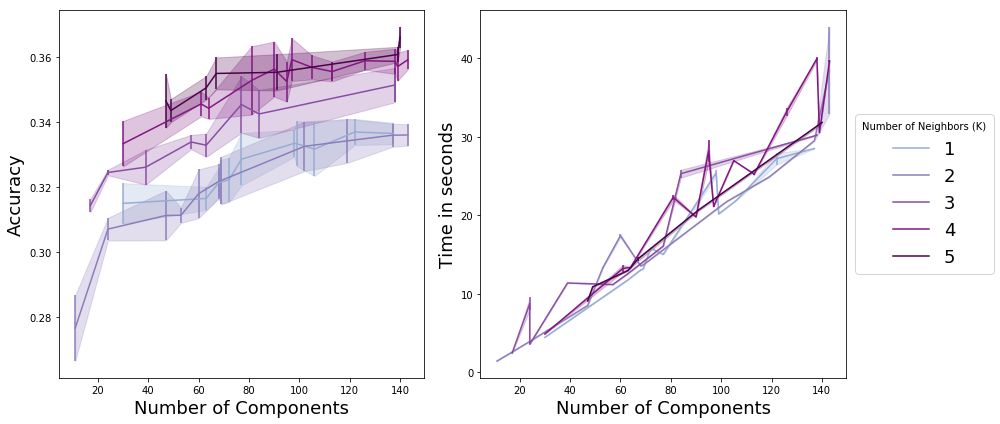

In [374]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
plt.ioff()

# For each subplot, define [var, var_std, xlabel, ylabel, title, legend?]
plot_array = [
#    [train_score, tr_sc_std, "", "F1 Score", "Train", True], # Showing legends on leftmost plot shows which integral values are present for each categorical value
    [test_score, te_sc_std, "Number of Components", "Accuracy", "Test", False],
    [compute_time, time_std, "Number of Components", "Time in seconds", "Time", False]
]

# Set colormap
scalarMap = mplcm.ScalarMappable(norm=colors.Normalize(vmin=-2, 
                                                       vmax=len(np.unique(integral))), 
                                 cmap=plt.get_cmap('BuPu'))

fs = 18

# Define legend for all values of integral
fig_t = plt.figure();
for i in np.unique(integral):
    plt.plot([],[],label=i, color=scalarMap.to_rgba(i))
handles, labels = fig_t.axes[0].get_legend_handles_labels()
plt.close(fig_t);

dim_h = len(plot_array)             # horizontal number of subplots
dim_v = len(np.unique(categorical)) # vertical number of subplots
p = 0                               # subplot count
fig = plt.figure(figsize=[12,6]);
for i in np.unique(categorical):
    vals_used = np.unique(integral[categorical == i])
    for j in range(dim_h):
        p = p+1
        ax = fig.add_subplot(dim_v, dim_h, p);
        for k in vals_used:
            mask = np.logical_and(categorical == i, integral == k)
            x = np.array(continuous[mask], dtype='float64') # *SearchCV uses dtype 'object'
            ind_sort = np.argsort(x) # order by x values for line plot
            x = x[ind_sort]
            y = plot_array[j][0][mask][ind_sort]
            y_stds = plot_array[j][1][mask][ind_sort]
            # Show line plot with error bars
            _ = plt.errorbar(x, y, yerr=y_stds, label=k, color=scalarMap.to_rgba(k))
            # Show confidence interval as shaded region
            _ = plt.fill_between(x, y - y_stds, y + y_stds, color=scalarMap.to_rgba(k), alpha=.25)
        
        _ = plt.xlabel(plot_array[j][2], fontsize=fs);
        _ = plt.ylabel(plot_array[j][3], fontsize=fs);
#        if j==1:
#            subtitle=("Various k with '%s' update method (KNN params)\n\n" % i)
#        else:
#            subtitle=""
#        _ = plt.title(subtitle+plot_array[j][4]);
        if plot_array[j][5]:
            _ = plt.legend(loc='upper left', fontsize=fs);
# Add legends to right of plots
for i in range(int(p/dim_h)):
    fig.axes[(i+1)*dim_h-1].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Number of Neighbors (K)", fontsize=fs)

plt.tight_layout()
plt.show()


## Experiment 2: Latent Dirichlet Allocation

Each run takes about half an hour with 15 minutes of overhead

In [320]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import uniform as sp_uniform
from scipy.stats import randint as sp_randint

X = tfidf[downsample_idns,:]

steps  = [
    LatentDirichletAllocation(random_state=0, n_jobs=1, learning_method='online'),
    KNeighborsClassifier(4, weights='distance'),
]
parameters = [ 
    (1, 'n_components',    [60,140]), 
    (1, 'learning_decay',  sp_uniform(0.51, 1.0)),
    (1, 'learning_offset', [2,8,14,20]),
]
total_n = 36

hp_search_2, results_2 = run_hp_search(X, y, steps, parameters, total_n)

(categorical, continuous, integral), compute_time, time_std, test_score, te_sc_std, train_score, tr_sc_std = results_2


Tuning hyper-parameters...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\sfzba\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:782: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
C:\Users\sfzba\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:782: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
C:\Users\sfzba\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:782: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
C:\Users\sfzba\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:782: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
C:\Users\sfzba\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:782: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
C:\Users\sfzba\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:782: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
[Par

done in 42615.693 seconds.



In [398]:
(categorical, continuous, integral), compute_time, time_std, test_score, te_sc_std, train_score, tr_sc_std = LDA_combined
mask = np.logical_and(time_std<2400, categorical==60)
#mask = time_std<2400
#mask = categorical==60
(continuous, integral, categorical), compute_time, time_std, test_score, te_sc_std, train_score, tr_sc_std = (continuous[mask], integral[mask], categorical[mask]), compute_time[mask], time_std[mask], test_score[mask], te_sc_std[mask], train_score[mask], tr_sc_std[mask]


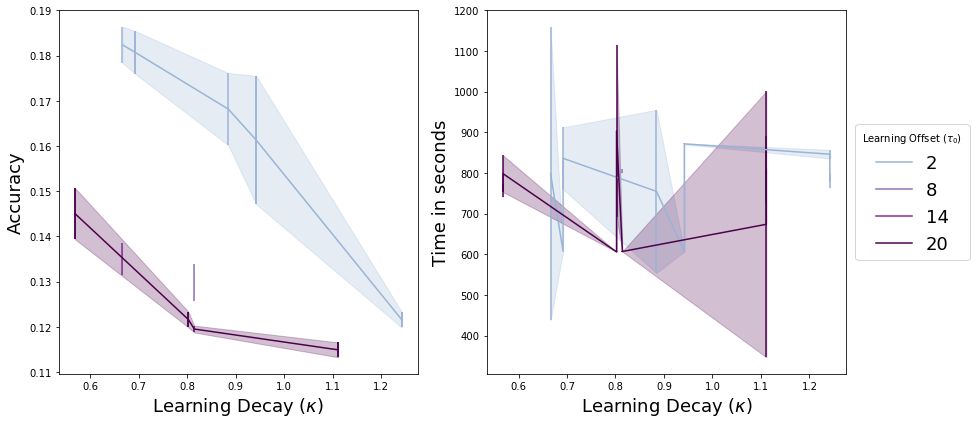

In [399]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
plt.ioff()

# For each subplot, define [var, var_std, xlabel, ylabel, title, legend?]
plot_array = [
#    [train_score, tr_sc_std, "", "F1 Score", "Train", True], # Showing legends on leftmost plot shows which integral values are present for each categorical value
    [test_score, te_sc_std, "Learning Decay ($\kappa$)", "Accuracy", "Test", False],
    [compute_time, time_std, "Learning Decay ($\kappa$)", "Time in seconds", "Time", False]
]

# Set colormap
scalarMap = mplcm.ScalarMappable(norm=colors.Normalize(vmin=-10, 
                                                       vmax=max(np.unique(integral))), 
                                 cmap=plt.get_cmap('BuPu'))

fs = 18

# Define legend for all values of integral
fig_t = plt.figure();
for i in np.unique(integral):
    plt.plot([],[],label=i, color=scalarMap.to_rgba(i))
handles, labels = fig_t.axes[0].get_legend_handles_labels()
plt.close(fig_t);

dim_h = len(plot_array)             # horizontal number of subplots
dim_v = len(np.unique(categorical)) # vertical number of subplots
p = 0                               # subplot count
fig = plt.figure(figsize=[12,6]);
for i in np.unique(categorical):
    vals_used = np.unique(integral[categorical == i])
    for j in range(dim_h):
        p = p+1
        ax = fig.add_subplot(dim_v, dim_h, p);
        for k in vals_used:
            mask = np.logical_and(categorical == i, integral == k)
            x = np.array(continuous[mask], dtype='float64') # *SearchCV uses dtype 'object'
            ind_sort = np.argsort(x) # order by x values for line plot
            x = x[ind_sort]
            y = plot_array[j][0][mask][ind_sort]
            y_stds = plot_array[j][1][mask][ind_sort]
            # Show line plot with error bars
            _ = plt.errorbar(x, y, yerr=y_stds, label=k, color=scalarMap.to_rgba(k))
            # Show confidence interval as shaded region
            _ = plt.fill_between(x, y - y_stds, y + y_stds, color=scalarMap.to_rgba(k), alpha=.25)
        
        _ = plt.xlabel(plot_array[j][2], fontsize=fs);
        _ = plt.ylabel(plot_array[j][3], fontsize=fs);
#         if j==1:
#             subtitle=("Various Learning Offsets ("+r"$\tau_0$"+") with %d components\n\n" % i)
#         else:
#             subtitle=""
#         _ = plt.title(subtitle+plot_array[j][4]);
        if plot_array[j][5]:
            _ = plt.legend(loc='upper left');
# Add legends to right of plots
for i in range(int(p/dim_h)):
    fig.axes[(i+1)*dim_h-1].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title=r"Learning Offset ($\tau_0$)", fontsize=fs)

plt.tight_layout()
plt.show()


## Experiment 3: doc2vec

In [338]:
from sklearn.base import BaseEstimator, TransformerMixin
import inspect
from gensim.models import Doc2Vec

class doc2vec_wrapper(BaseEstimator, TransformerMixin):  
    """Enable sci-kit learn GridSearchCV with gensim doc2vec"""

    def __init__(self, n_components=0, iter=0, dm=1):
        """
        Called when initializing the classifier
        """
        self.n_components=0
        self.iter=0
        self.dm=1
        self.model = None

    def fit(self, X, y=0):
        """
        Build vocabulary and train the model
        X            -- List of gensim labelled sentence objects
        n_components -- Dimensionality of document vectors. gensim calls this 'size'
        iter         -- Maximum number of SGD iterations
        dm           -- Flavor of doc2vec: {0: PV-DBOW, 1: PV-DM}. See Le & Mikolov paper for details
        """
        self.model = Doc2Vec(min_count=2, size=self.n_components, iter=self.iter, dm=self.dm)
        self.model.build_vocab(X)
        self.model.train(X, total_examples=self.model.corpus_count, epochs=self.model.iter)
        return self

    def transform(self, X):
        """
        Transform gensim sentence vectors
        """
        n_docs = len(X)
        X_trans = np.empty([n_docs, self.n_components])
        for i in range(n_docs):
            X_trans[i,:] = self.model.infer_vector(X[i].words)
        return X_trans


In [339]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import uniform as sp_uniform
from scipy.stats import randint as sp_randint

#X = [sent for i, sent in enumerate(sentences) if i in downsample_idns]

steps  = [
    doc2vec_wrapper(),
    KNeighborsClassifier(),
]

parameters = [ 
    (1, 'n_components', [60,140]), 
    (1, 'iter', sp_randint(10, 150)),
    (1, 'dm', [0,1]),
]

total_n = 48

hp_search_3, results_3 = run_hp_search(X, y, steps, parameters, total_n)

(integral, continuous, categorical), compute_time, time_std, test_score, te_sc_std, train_score, tr_sc_std = results_3


Tuning hyper-parameters...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 131.0min finished


done in 8004.909 seconds.



In [391]:
(integral, continuous, categorical), compute_time, time_std, test_score, te_sc_std, train_score, tr_sc_std = results_3
mask = categorical==0
(continuous, integral, categorical), compute_time, time_std, test_score, te_sc_std, train_score, tr_sc_std = (continuous[mask], integral[mask], categorical[mask]), compute_time[mask], time_std[mask], test_score[mask], te_sc_std[mask], train_score[mask], tr_sc_std[mask]


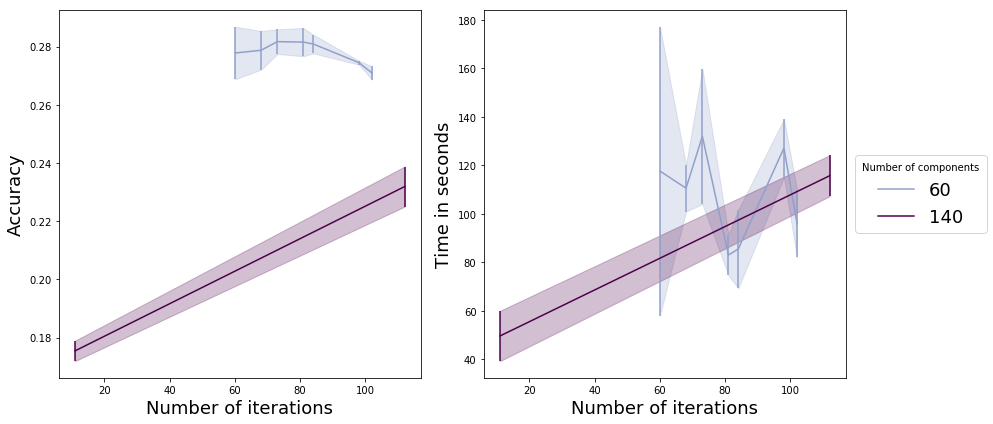

In [395]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
plt.ioff()

# For each subplot, define [var, var_std, xlabel, ylabel, title, legend?]
plot_array = [
#    [train_score, tr_sc_std, "", "F1 Score", "Train", True], # Showing legends on leftmost plot shows which integral values are present for each categorical value
    [test_score, te_sc_std, "Number of iterations", "Accuracy", "", False],
    [compute_time, time_std, "Number of iterations", "Time in seconds", "", False]
]

# Set colormap
scalarMap = mplcm.ScalarMappable(norm=colors.Normalize(vmin=-10, 
                                                       vmax=max(np.unique(integral))), 
                                 cmap=plt.get_cmap('BuPu'))

fs = 18

# Define legend for all values of integral
fig_t = plt.figure();
for i in np.unique(integral):
    plt.plot([],[],label=i, color=scalarMap.to_rgba(i))
handles, labels = fig_t.axes[0].get_legend_handles_labels()
plt.close(fig_t);

dim_h = len(plot_array)             # horizontal number of subplots
dim_v = len(np.unique(categorical)) # vertical number of subplots
p = 0                               # subplot count
fig = plt.figure(figsize=[12,6]);
for i in np.unique(categorical):
    vals_used = np.unique(integral[categorical == i])
    for j in range(dim_h):
        p = p+1
        ax = fig.add_subplot(dim_v, dim_h, p);
        for k in vals_used:
            mask = np.logical_and(categorical == i, integral == k)
            x = np.array(continuous[mask], dtype='float64') # *SearchCV uses dtype 'object'
            ind_sort = np.argsort(x) # order by x values for line plot
            x = x[ind_sort]
            y = plot_array[j][0][mask][ind_sort]
            y_stds = plot_array[j][1][mask][ind_sort]
            # Show line plot with error bars
            _ = plt.errorbar(x, y, yerr=y_stds, label=k, color=scalarMap.to_rgba(k))
            # Show confidence interval as shaded region
            _ = plt.fill_between(x, y - y_stds, y + y_stds, color=scalarMap.to_rgba(k), alpha=.25)
        
        _ = plt.xlabel(plot_array[j][2], fontsize=fs);
        _ = plt.ylabel(plot_array[j][3], fontsize=fs);
        # if j==0:
        #     if i==0: subtitle="PV-DBOW"
        #     if i==1: subtitle="PV-DM"
        # else:
        #     subtitle=""
        # _ = plt.title(subtitle+plot_array[j][4], fontsize=fs);
        # if plot_array[j][5]:
        #     _ = plt.legend(loc='upper left', fontsize=fs);
# Add legends to right of plots
for i in range(int(p/dim_h)):
    fig.axes[(i+1)*dim_h-1].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Number of components", fontsize=fs)

plt.tight_layout()
plt.show()
